# Solving a SOLA problem using the Problem class

The Problem class in the SOLA_DLI file contains all the tools for solving a SOLA problem within the "property bounds perspective". We start as usual by importing the needed packages

In [125]:
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.spaces import PCb, DirectSumSpace, RN
from core.aux.normal_data import load_normal_data
from core.main_classes.functions import *
from core.main_classes.mappings import *
from core.main_classes.SOLA_DLI import Problem
from core.aux.other import round_to_sf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set global parameters for matplotlib
plt.rcParams.update({'font.size': 15})  # Set default font size
plt.rcParams['axes.linewidth'] = 1.5  # Set the thickness of the axes lines


Before even attempting to SOLVE a SOLA problem we must first define the mappings and spaces that we will work in. We will build these mathematical components one by one starting with the model space. 

The lines of codes in the "Edit regions" can be modified to explore variations of the given default SOLA problem.

In [126]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['vs', 'vp', 'rho']
# Edit region -------------

physical_parameters_symbols = {'vs': '$\delta lnv_s$', 'vp': '$\delta lnv_p$', 'rho': '$\delta ln rho$'}
no_of_params = len(physical_parameters)
EarthDomain = HyperParalelipiped(bounds=[[0, 6371]], fineness=1000)
constituent_models_spaces = [PCb(domain=EarthDomain) for _ in physical_parameters]
# Create a dictionary with physical_parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = DirectSumSpace(tuple(constituent_models_spaces))

Then the data space. This is also where we iport the sensitivity kernels.

In [127]:
###################
# Create Data space
###################
# Edit region -------------
data_directory = '/disks/data/PhD/BGSOLA/SOLA_DLI/kernels_modeplotaat_Adrian'
which_data = list(np.arange(0, 140))
# Edit region -------------

# Import sensitivity data
how_many_data = len(which_data)
raw_sensitivity_dict = {}
raw_sensitivity_domains_dict = {}
for param in physical_parameters:
    raw_sensitivity_domain, raw_sensitivity = load_normal_data(param, data_directory)
    raw_sensitivity_dict[param] = np.array(raw_sensitivity)[which_data]
    if param not in raw_sensitivity_domains_dict:
        raw_sensitivity_domains_dict[param] = raw_sensitivity_domain
D = RN(dimension=how_many_data)

The the model-data mapping.

In [128]:
###########################
# Create model-data mapping 
###########################
# Make them into functions via interpolation
sensitivity_dict = {}
for param in physical_parameters:
    sensitivity_dict[param] = []
    for discrete_sensitivity_kernel in raw_sensitivity_dict[param]:
        sensitivity_dict[param].append(Interpolation_1D(values=discrete_sensitivity_kernel,
                                                        raw_domain=raw_sensitivity_domains_dict[param],
                                                        domain=EarthDomain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=D, 
                                        kernels=sensitivity_dict[param]) for param in physical_parameters]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
G = DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

In [129]:
###################################
# Create property mapping and space
###################################
# Edit region -------------
target_types = {'vs': Gaussian_1D,
                'vp': Null_1D,
                'rho': Null_1D}
width = 1000 # same units as domain (km here)
how_many_targets = 100
enquiry_points = np.linspace(EarthDomain.bounds[0][0], 
                             EarthDomain.bounds[0][1], 
                             how_many_targets)
# Edit region -------------
P = RN(dimension=how_many_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for i in range(how_many_targets):
        if target_type == Gaussian_1D:
            targets_dict[param].append(target_type(domain=EarthDomain,
                                                   center=enquiry_points[i],
                                                   width=width))
        else: 
            targets_dict[param].append(target_type(domain=EarthDomain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=P, 
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))

In [130]:
# Create color Palette
colors = sns.color_palette('YlGnBu', n_colors=100)

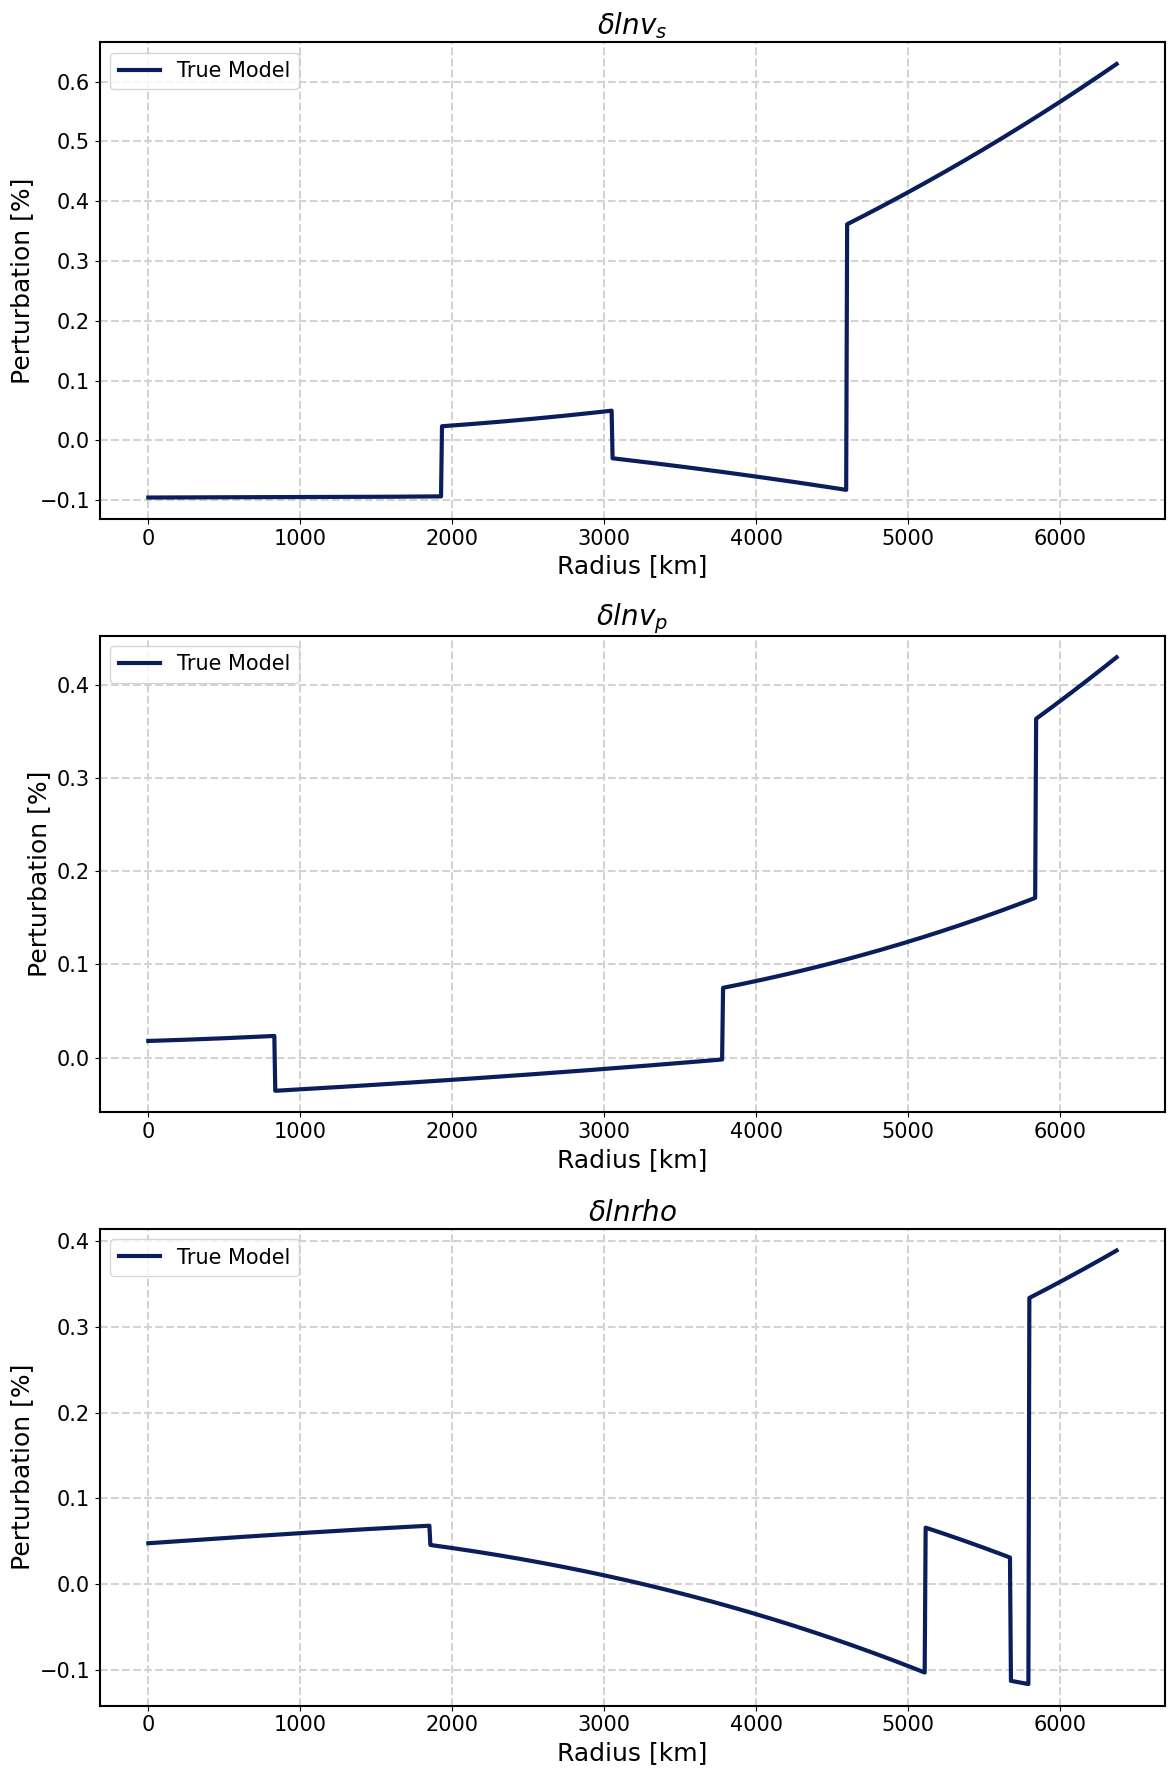

In [131]:
%matplotlib inline
#################################
# Create fake true model and data
#################################
true_model = M.random_member(args_list=[(4,), (3,), (13,)])
data = G.map(true_model)

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes[i].plot(EarthDomain.mesh, submodel.evaluate(EarthDomain.mesh)[1], 
            label='True Model', color=colors[99], linewidth=3)
    axes[i].set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
    axes[i].set_xlabel('Radius [km]', fontsize=18)
    axes[i].set_ylabel('Perturbation [%]', fontsize=18)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    axes[i].legend(fontsize=15)
    axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('truth.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()

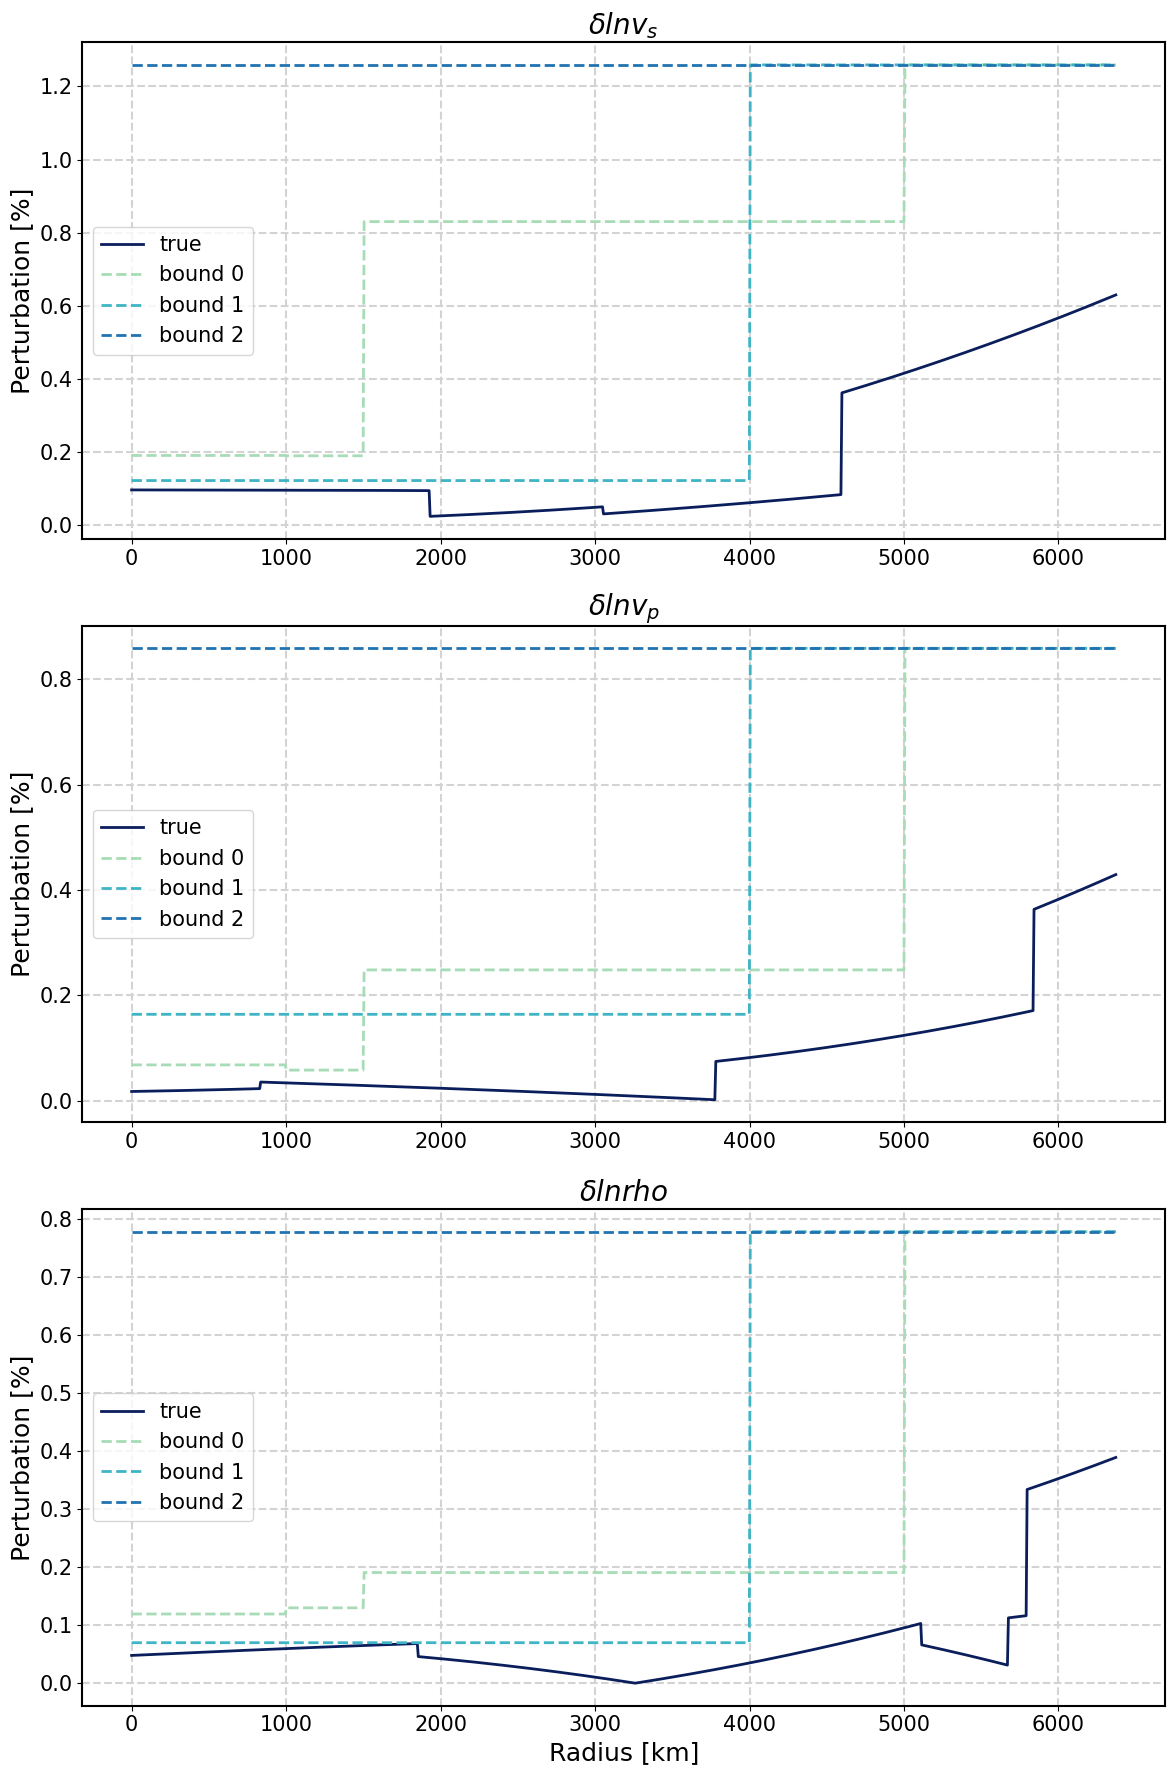

In [138]:
####################
# Compute norm bound
####################
# Edit region -------------
# Places where the true model will be evaluated
intervals = [np.array([0,1000, 1500, 5000, EarthDomain.bounds[0][1]]),
            np.array([0, 4000, EarthDomain.bounds[0][1]]),
            np.array([0, EarthDomain.bounds[0][1]])]
# Edit region -------------
upper_bounds = {}
for model, param in zip(true_model, physical_parameters):
    upper_bounds[param] = []
    for interval in intervals:
        values = np.abs(model.evaluate(interval[1:])[1])*2
        upper_bound = Piecewise_1D(domain=model.domain,
                                intervals=interval,
                                values=values)
        upper_bounds[param].append(upper_bound)

norm_bounds = []
for bound_tuple in zip(*upper_bounds.values()):
    norm_bounds.append(M.norm(bound_tuple))

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes[i].plot(EarthDomain.mesh, np.abs(submodel.evaluate(EarthDomain.mesh)[1]), 
            label='true', color=colors[99], linewidth=2)
    # Set title and labels
    axes[i].set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
    axes[i].set_ylabel('Perturbation [%]', fontsize=18)
    # Set tick parameters
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    # Add legend
    axes[i].legend(fontsize=15)
    axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
for bound_no, bound_tuple in enumerate(zip(*upper_bounds.values())):
    for i, bound in enumerate(bound_tuple):
        axes[i].plot(EarthDomain.mesh, bound.evaluate(EarthDomain.mesh)[1], 
                label='bound ' + str(bound_no), color=colors[30 + bound_no*20], linestyle='--', linewidth=2)
        axes[i].legend(fontsize=15, loc='center left')
plt.xlabel('Radius [km]', fontsize=18)
plt.tight_layout()
plt.savefig('bound.png', bbox_inches='tight')
plt.show()

Now with all the components at hand, we put them all in a "Problem" class instance

In [139]:
problem = Problem(M=M, D=D, P=P, G=G, T=T, norm_bound=norm_bounds[0], data=data)

In [140]:
problem.solve()

In [141]:
# Compute True property
true_property = T.map(true_model)

With the problem solved, we will find the solution (property bounds) in "problem.solution" and we can plot it.

25.352457566107528
134.47995213172524
142.94485423385748
231.16560788161308


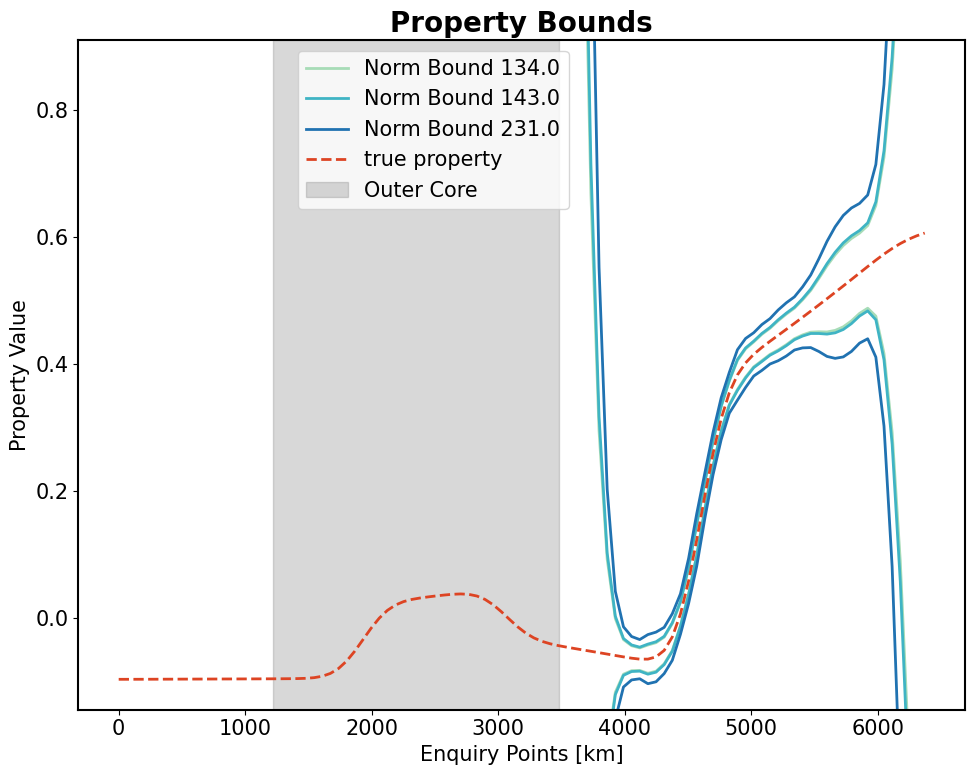

In [146]:
###############
# Plot solution
###############
print(problem.least_norm)
# Find limits for y axis
y_max = np.max(true_property)*1.5
y_min = np.min(true_property)*1.5
# Plot the Solution section
plt.figure('Solution', figsize=(10, 8))
plt.title('Property Bounds', fontsize=20, fontweight='bold')  # Increase font size and add bold
for index, upper_bound in enumerate(norm_bounds):
    problem.change_bound(upper_bound)
    problem.solve()
    print(upper_bound)
    plt.plot(enquiry_points, problem.solution['upper bound'], color=colors[30 + index*20], 
            linewidth=2, label='Norm Bound ' + str(round_to_sf(upper_bound, 3)))  # Increase line width
    plt.plot(enquiry_points, problem.solution['lower bound'], color=colors[30 + index*20], 
            linewidth=2)  # Increase line width and use dashed line
plt.plot(enquiry_points, true_property, color='#dd4423', linestyle='--', 
         linewidth=2, label='true property')
plt.fill_betweenx([y_min, y_max], 1220, 3480, color='gray', alpha=0.3, label='Outer Core')
plt.ylim([y_min, y_max])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper center', bbox_to_anchor=(0.4, 1))

plt.xlabel('Enquiry Points [km]', fontsize=15)  # Add X-axis label with fontsize
plt.ylabel('Property Value', fontsize=15)  # Add Y-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('new_solution.png', dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()